# Выбор локации для скважины

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

Цель: Решить, где бурить новую скважину. 

## Загрузка и подготовка данных

In [2]:
#Импорт библиотек
import pandas as pd
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
import numpy as np
import warnings
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.options.mode.chained_assignment = None
from joblib import dump

In [2]:
plt.style.use("ggplot")
rcParams['figure.figsize'] = (6,  3)

### Загрузка данных

In [3]:
try:
    data_0 = pd.read_csv('/datasets/geo_data_0.csv', sep = ',')
    data_1 = pd.read_csv('/datasets/geo_data_1.csv', sep = ',')
    data_2 = pd.read_csv('/datasets/geo_data_2.csv', sep = ',')
except:
    data_0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
    data_1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
    data_2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [4]:
data_0.head()

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


In [5]:
data_1.head()

,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


In [6]:
data_2.head()

,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


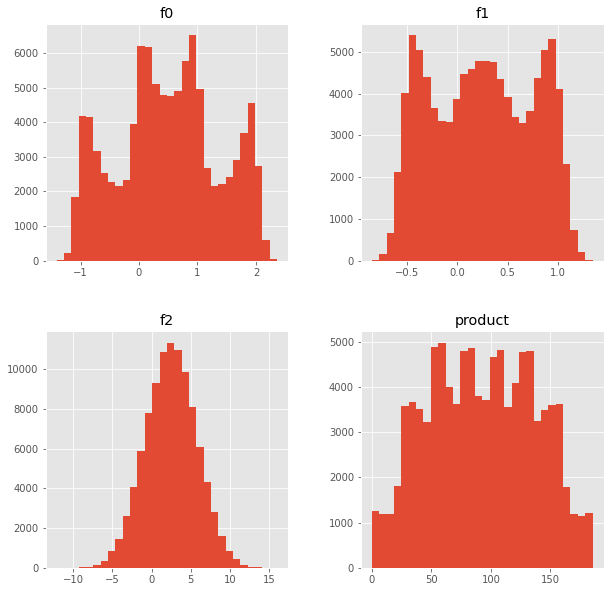

In [7]:
data_0.hist(figsize=(10, 10), bins = 30)
plt.show()

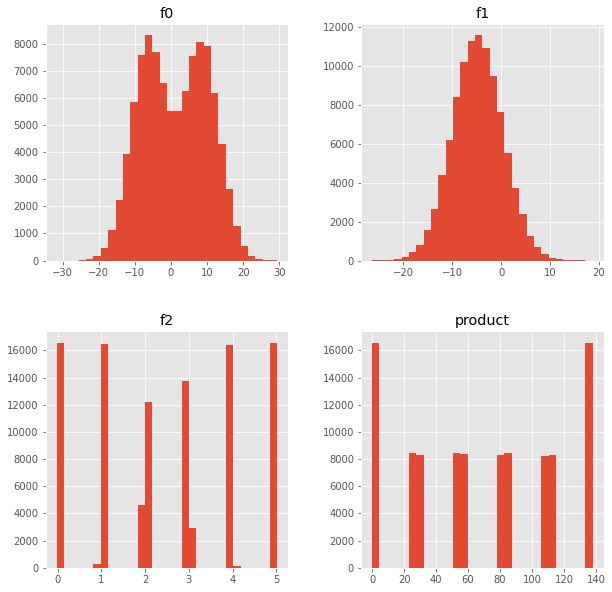

In [8]:
data_1.hist(figsize=(10, 10), bins = 30)
plt.show()

Заметна высокая дисперсия параметра f2 у Региона 1, распределение product также отличается от распределений Региона 0 и Региона 2. Исследуем это далее

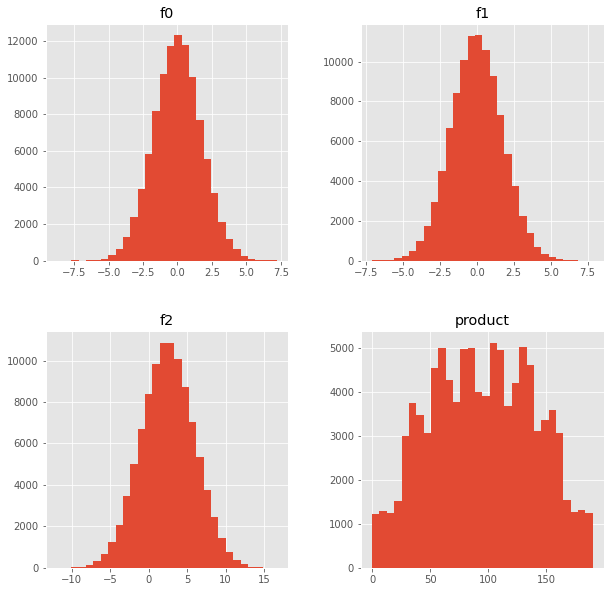

In [9]:
data_2.hist(figsize=(10, 10), bins = 30)
plt.show()

### Исследование данных

#### Пустые строки и дубликаты

In [10]:
data_0.info()
data_1.info()
data_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null 

Пустые строки отсутствуют

In [11]:
data_0.duplicated().sum()

0

In [12]:
data_1.duplicated().sum()

0

In [13]:
data_2.duplicated().sum()

0

Дубликаты не найдены

#### Корреляция данных

In [14]:
data_0.corr()

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [15]:
data_1.corr()

,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [16]:
data_2.corr()

,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


Наблюдается высокая корреляция между *f2* и *product* в *Регионе 1*, это может повлиять на результат обучения модели. Судя по всему, необходимо удалить признак f2, чтобы это не повлияло на обучение модели линейной регрессии

In [17]:
#data_1_2 = data_1.drop(["f2"],axis = 1)

### Вывод

* Пустые строки и дубликаты не найдены
* Путем исследования корреляции выявлено, что наблюдается высокая корреляция между *f2* и *product* в *Регионе 1*, это может повлиять на результат обучения модели. 

## Обучение и проверка модели

###  Разбейте данные на обучающую и валидационную выборки в соотношении 75:25.
Оба пункта см. ниже
### Обучите модель и сделайте предсказания на валидационной выборке.

In [18]:
# Определение функции для обучения и оценки модели
def train_and_evaluate_model(data):
    # Разделим данные на тренировочную и валидационную выборки
    features = data.drop(['id', 'product'], axis=1)
    target = data['product']
    features_train, features_valid, target_train, target_valid = train_test_split(
        features, target, test_size=0.25, random_state=12345)
    
    # Масштабирование функций с помощью StandardScaler
    scaler = StandardScaler()
    scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    # Обучение линейной регрессионной модели на обучающей выборке
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    # Делаем прогнозы на валидационной выборке
    predicted_valid = model.predict(features_valid)
   
    
    # Сохраняем прогнозы и правильные ответы на валидационной выборке
    valid_predictions = pd.DataFrame({'predicted': predicted_valid, 'actual': target_valid})
    
    return valid_predictions

### Сохраните предсказания и правильные ответы на валидационной выборке.

In [19]:
# Обучение и оценка модели для каждого региона
valid_predictions_0 = train_and_evaluate_model(data_0)
valid_predictions_1 = train_and_evaluate_model(data_1)
valid_predictions_2 = train_and_evaluate_model(data_2)

In [20]:
valid_predictions_0.head(5)

,predicted,actual
71751,95.894952,10.038645
80493,77.572583,114.551489
2655,77.892640,132.603635
53233,90.175134,169.072125
91141,70.510088,122.325180


### Напечатайте на экране средний запас предсказанного сырья и RMSE модели.

In [21]:
# Определение функции для расчета среднего предсказанного запаса сырья и RMSE модели
def evaluate_model(predictions):
    # Вычисление среднего прогнозируемого запаса сырья и среднего фактического
    avg_predicted_stock = predictions['predicted'].mean()
    avg_actual_stock = predictions['actual'].mean()
    
    # Расчет RMSE модели
    #rmse = np.sqrt(((predictions['predicted'] - predictions['actual']) ** 2).mean())
    rmse = (mean_squared_error(predictions['actual'], predictions['predicted']))**0.5
    
    return avg_predicted_stock, avg_actual_stock, rmse

# Оценка модели для каждого региона
avg_predicted_stock_0, avg_actual_stock_0, rmse_0 = evaluate_model(valid_predictions_0)
avg_predicted_stock_1, avg_actual_stock_1, rmse_1 = evaluate_model(valid_predictions_1)
avg_predicted_stock_2, avg_actual_stock_2, rmse_2 = evaluate_model(valid_predictions_2)

# Вывод результатов
print('Регион 0:')
print('Средний прогнозируемый запас в регионе: {:.2f}'.format(avg_predicted_stock_0))
print('Средний фактический запас в регионе: {:.2f}'.format(avg_actual_stock_0))
print('RMSE: {:.2f}'.format(rmse_0))
print()
print('Регион 1:')
print('Средний прогнозируемый запас в регионе: {:.2f}'.format(avg_predicted_stock_1))
print('Средний фактический запас в регионе: {:.2f}'.format(avg_actual_stock_1))
print('RMSE: {:.2f}'.format(rmse_1))
print()
print('Регион 2:')
print('Средний прогнозируемый запас в регионе: {:.2f}'.format(avg_predicted_stock_2))
print('Средний фактический запас в регионе: {:.2f}'.format(avg_actual_stock_2))
print('RMSE: {:.2f}'.format(rmse_2))
print()


Регион 0:
Средний прогнозируемый запас в регионе: 92.59
Средний фактический запас в регионе: 92.08
RMSE: 37.58

Регион 1:
Средний прогнозируемый запас в регионе: 68.73
Средний фактический запас в регионе: 68.72
RMSE: 0.89

Регион 2:
Средний прогнозируемый запас в регионе: 94.97
Средний фактический запас в регионе: 94.88
RMSE: 40.03



Этот код определяет функцию для расчета среднего предсказанного запаса сырья и **RMSE** модели, и оценивает модель для каждого региона, используя данные **valid_predictions** из предыдущего шага. 

Полученные значения **avg_predicted_stock**, **avg_actual_stock** и **rmse** выводятся на экран.

Судя по всему, среднее фактическое значение и среднее предсказанное значение для регионов очень близки

### Вывод

Из результатов видно, что регион 1 имеет **наименьшее** значение **RMSE** = 0.89, что означает, что модель имеет наименьшее среднее отклонение от фактических значений для этого региона. 

Однако, регион 2 имеет самый высокий средний фактический (и прогнозируемый) запас сырья, что означает, что ожидаемое количество сырья, которое может быть добыто в этом регионе, выше.

Однако, чтобы принять окончательное решение о том, какой регион является наиболее прибыльным, нам также необходимо рассмотреть риски, связанные с каждым регионом. Мы можем использовать метод **Bootstrap** для моделирования различных исходов и расчета риска потерь для каждого региона. После анализа прибыли и рисков мы можем выбрать регион с наибольшей ожидаемой прибылью и наименьшим риском потерь.

## Подготовка к расчёту прибыли

### Рассчет объема сырья, достаточного для безубыточности

In [22]:
# Создание переменных
BUDGET = 10_000_000_000  # 10 млрд
PRICE_PER_BARREL = 450_000  # 450 рублей за баррель
POINTS_TO_SELECT = 200

# Рассчет объема сырья, достаточного для безубыточности новой скважины
breakeven_volume = BUDGET / (PRICE_PER_BARREL * POINTS_TO_SELECT)
print("Количество сырья, необходимого для безубыточности новой скважины, составляет {:.2f} тыс. баррелей.".format(breakeven_volume))
print()
# Сравнение полученного объёма сырья со средним запасом в каждом регионе
print("Средний прогнозируемый запас в регионе 0: {:.2f} тыс. баррелей".format(avg_predicted_stock_0))
print("Средний прогнозируемый запас в регионе 1: {:.2f} тыс. баррелей".format(avg_predicted_stock_1))
print("Средний прогнозируемый запас в регионе 2: {:.2f} тыс. баррелей".format(avg_predicted_stock_2))
print()
print("Средний фактический запас в регионе 0: {:.2f} тыс. баррелей".format(avg_actual_stock_0))
print("Средний фактический запас в регионе 1: {:.2f} тыс. баррелей".format(avg_actual_stock_1))
print("Средний фактический запас в регионе 2: {:.2f} тыс. баррелей".format(avg_actual_stock_2))


Количество сырья, необходимого для безубыточности новой скважины, составляет 111.11 тыс. баррелей.

Средний прогнозируемый запас в регионе 0: 92.59 тыс. баррелей
Средний прогнозируемый запас в регионе 1: 68.73 тыс. баррелей
Средний прогнозируемый запас в регионе 2: 94.97 тыс. баррелей

Средний фактический запас в регионе 0: 92.08 тыс. баррелей
Средний фактический запас в регионе 1: 68.72 тыс. баррелей
Средний фактический запас в регионе 2: 94.88 тыс. баррелей


**Выводы подготовительного этапа расчета прибыли:**

Объем сырья, необходимый для безубыточности новой скважины, составляет 111,11 тыс. баррелей.
Средний фактический запас в каждом регионе ниже безубыточного запаса.

In [23]:
valid_predictions_0.describe()

,predicted,actual
count,25000.000000,25000.000000
mean,92.592568,92.078597
std,23.176994,44.286913
min,-9.367846,0.004022
25%,76.652232,56.059494
50%,92.661884,90.897664
75%,108.437632,128.160698
max,180.180713,185.315412


In [24]:
valid_predictions_1.describe()

,predicted,actual
count,25000.000000,25000.000000
mean,68.728547,68.723136
std,46.010225,46.022165
min,-1.893774,0.000000
25%,28.536661,26.953261
50%,57.851586,57.085625
75%,109.346485,107.813044
max,139.818970,137.945408


In [25]:
valid_predictions_2.describe()

,predicted,actual
count,25000.000000,25000.000000
mean,94.965046,94.884233
std,19.853733,44.902982
min,17.131597,0.000000
25%,81.388500,59.217876
50%,95.031204,94.979468
75%,108.492663,130.568416
max,165.856833,190.010982


### Сравнение полученного объёма сырья со средним запасом в каждом регионе

In [26]:
print("25% скважин в нулевом регионе содержат больше сырья, чем ",
      round(valid_predictions_0["actual"].quantile(0.75),2))
print("25% скважин в нулевом регионе по предсказанию будут содержать больше сырья, чем ",
      round(valid_predictions_0["predicted"].quantile(0.75),2))
print("25% скважин в первом регионе содержат больше сырья, чем ",
      round(valid_predictions_1["actual"].quantile(0.75),2))
print("25% скважин в первом регионе по предсказанию будут содержать больше сырья, чем ",
      round(valid_predictions_1["predicted"].quantile(0.75),2))
print("25% скважин во втором регионе содержат больше сырья, чем ",
      round(valid_predictions_2["actual"].quantile(0.75),2))
print("25% скважин во втором регионе по предсказанию будут содержать больше сырья, чем ",
      round(valid_predictions_2["predicted"].quantile(0.75),2))

25% скважин в нулевом регионе содержат больше сырья, чем  128.16
25% скважин в нулевом регионе по предсказанию будут содержать больше сырья, чем  108.44
25% скважин в первом регионе содержат больше сырья, чем  107.81
25% скважин в первом регионе по предсказанию будут содержать больше сырья, чем  109.35
25% скважин во втором регионе содержат больше сырья, чем  130.57
25% скважин во втором регионе по предсказанию будут содержать больше сырья, чем  108.49


### Вывод

* В **Регионе 0** и **Регионе 2** в 25% скважин больше сырья, чем объем сырья, необходимый для безубыточности новой скважины, который составляет 111,11 тыс. баррелей
* Максимальный средний прогнозируемый объем в регионах (Регион 2) равен 94.97

## Расчёт прибыли и рисков 

In [27]:
def profit(target, predicted):
    #sort = pd.Series(predicted).sort_values(ascending=False)[:POINTS_TO_SELECT]
    #target_sort = target.loc[target.index.isin(sort.index)].reset_index(drop=True)
    
    sort = pd.Series(predicted).sort_values(ascending=False)
    target_sort = target[sort.index][:POINTS_TO_SELECT]


    # КОД РЕВЬЮЕРА, debug
    if target[sort.index].shape[0] != sort.index.shape[0]:
        print("Shape mismatch! Actual targets shape:", target_sort.shape)


    sum_true = target_sort.sum()
    return (sum_true * PRICE_PER_BARREL) - BUDGET

In [28]:
print("Прибыль с лучших 200 скважин в нулевом регионе:",profit(valid_predictions_0['actual'], valid_predictions_0['predicted']))
print("Прибыль с лучших 200 скважин в первом регионе:",profit(valid_predictions_1['actual'], valid_predictions_1['predicted']))
print("Прибыль с лучших 200 скважин во втором регионе:",profit(valid_predictions_2['actual'], valid_predictions_2['predicted']))

Прибыль с лучших 200 скважин в нулевом регионе: 3320826043.1398506
Прибыль с лучших 200 скважин в первом регионе: 2415086696.681511
Прибыль с лучших 200 скважин во втором регионе: 2710349963.5998325


In [29]:
def calculate_profit_distribution(target, predicted):
    samples = [profit(target, pd.Series(predicted).sample(n=500, replace=True, random_state=i)) for i in range(1000)]
    mean_profit = np.mean(samples)
    percent_loss = np.mean([sample < 0 for sample in samples]) * 100
    lower = np.quantile(samples, 0.025)
    upper = np.quantile(samples, 0.975)
    fig = plt.figure(figsize =(10, 7))
    # Создание box plot
    plt.boxplot(samples)
    plt.title("Диаграмма box plot")
    # show plot
    plt.show() 
    
    return mean_profit, lower,  upper,  percent_loss

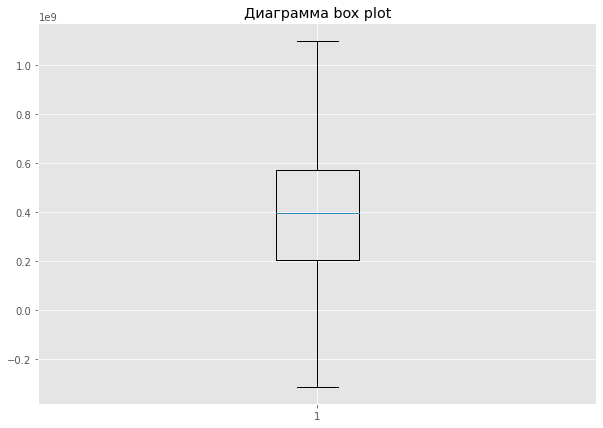

95% доверительный интервал для региона ноль лежит между: (-99868029.94, 877365288.83)
Среднее прогнозируемое значение прибыли 388.35 млн.
Процент риска 6.60%


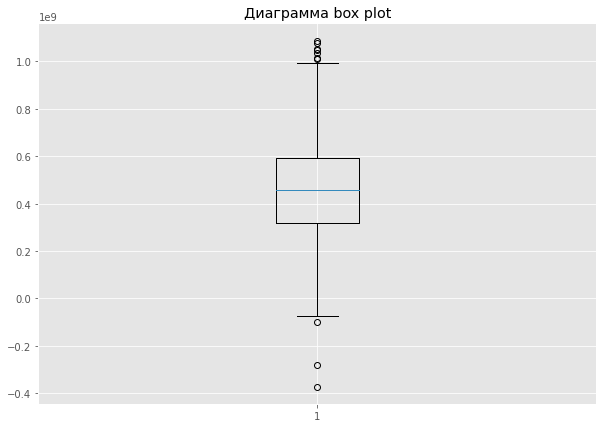

95% доверительный интервал для первого региона лежит между: (50258370.30, 872327130.12)
Среднее прогнозируемое значение прибыли 457.32 млн.
Процент риска 1.70%


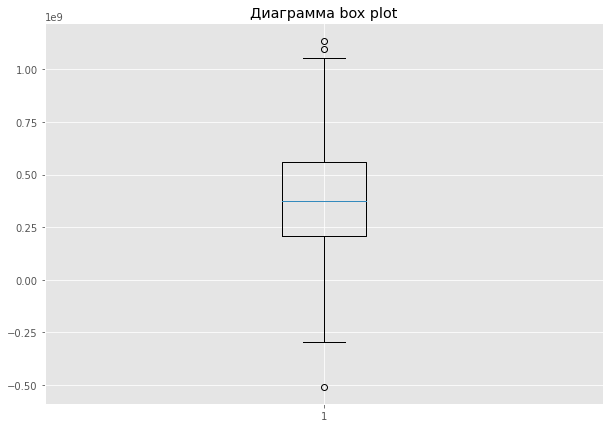

95% доверительный интервал для второго региона лежит между: (-95510056.50, 881318675.76)
Среднее прогнозируемое значение прибыли 387.55 млн.
Процент риска 6.50%


In [30]:
mean_profit0, lower0, upper0, percent_loss_0 = calculate_profit_distribution(valid_predictions_0['actual'], valid_predictions_0['predicted'])
print("95% доверительный интервал для региона ноль лежит между: ({:.2f}, {:.2f})".format(round(lower0,2), round(upper0,2)))
print('Среднее прогнозируемое значение прибыли {:.2f} млн.'.format(round(mean_profit0/1000000,2)))
print('Процент риска {:.2f}%'.format(round(percent_loss_0,2)))

mean_profit1, lower1, upper1, percent_loss_1 = calculate_profit_distribution(valid_predictions_1['actual'], valid_predictions_1['predicted'])
print("95% доверительный интервал для первого региона лежит между: ({:.2f}, {:.2f})".format(round(lower1,2), round(upper1,2)))
print('Среднее прогнозируемое значение прибыли {:.2f} млн.'.format(round(mean_profit1/1000000,2)))
print('Процент риска {:.2f}%'.format(round(percent_loss_1,2)))

mean_profit2, lower2, upper2, percent_loss_2 = calculate_profit_distribution(valid_predictions_2['actual'], valid_predictions_2['predicted'])
print("95% доверительный интервал для второго региона лежит между: ({:.2f}, {:.2f})".format(round(lower2,2), round(upper2,2)))
print('Среднее прогнозируемое значение прибыли {:.2f} млн.'.format(round(mean_profit2/1000000,2)))
print('Процент риска {:.2f}%'.format(round(percent_loss_2,2)))


## Вывод

**Регион 0**
* Средний прогнозируемый запас в регионе 0: 92.59 тыс. баррелей
* 95% доверительный интервал для региона ноль лежит между: (-99868029.94, 877365288.83)
* Среднее прогнозируемое значение прибыли 388.35 млн.
* Процент риска 6.60%

**Регион 1**
* Средний прогнозируемый запас в регионе: 68.86
* Регион 1 имеет **наименьшее** значение **RMSE** = 0.89, что означает, что модель имеет наименьшее среднее отклонение от фактических значений для этого региона
* 95% доверительный интервал для первого региона лежит между: (50258370.30, 872327130.12)
* Среднее прогнозируемое значение прибыли 457.32 млн.
* Процент риска 1.70%


**Регион 2**
* Имеет самый высокий средний прогнозируемый запас сырья, что означает, что ожидаемое количество сырья, которое может быть добыто в этом регионе, выше
* Средний прогнозируемый запас в регионе 2: 94.97 тыс. баррелей
* 95% доверительный интервал для второго региона лежит между: (-95510056.50, 881318675.76)
* Среднее прогнозируемое значение прибыли 387.55 млн.
* Процент риска 6.50%

**Итог:** Для дальнейших работ по уровню риска < 2.5%  подходит **регион 1**, его уровень риска  1.70%. Среднее прогнозируемое значение прибыли 457.32 млн. Регион 1 имеет **наименьшее** значение **RMSE** = 0.89, что означает, что модель имеет наименьшее среднее отклонение от фактических значений для этого региона

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован